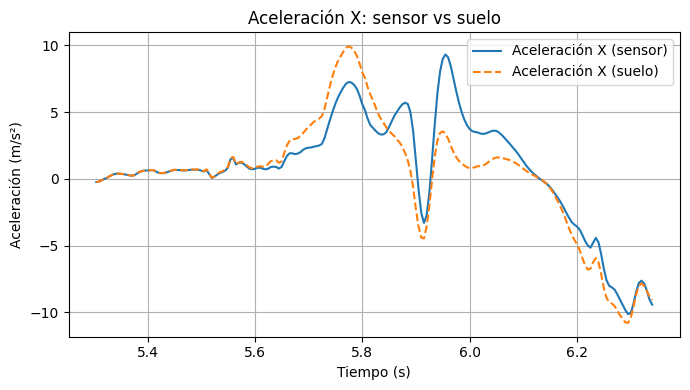

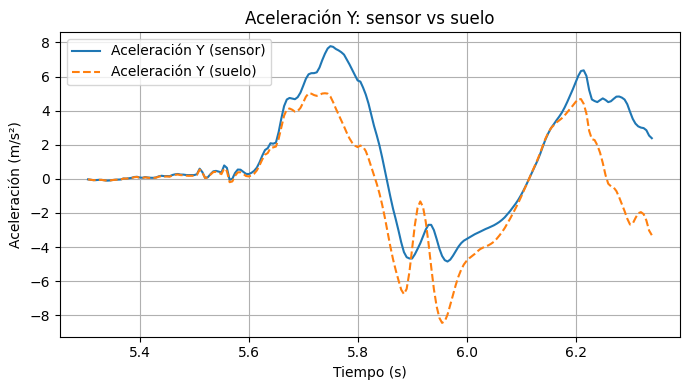

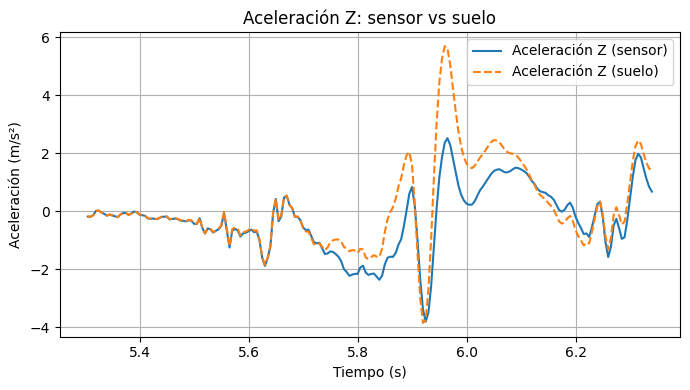

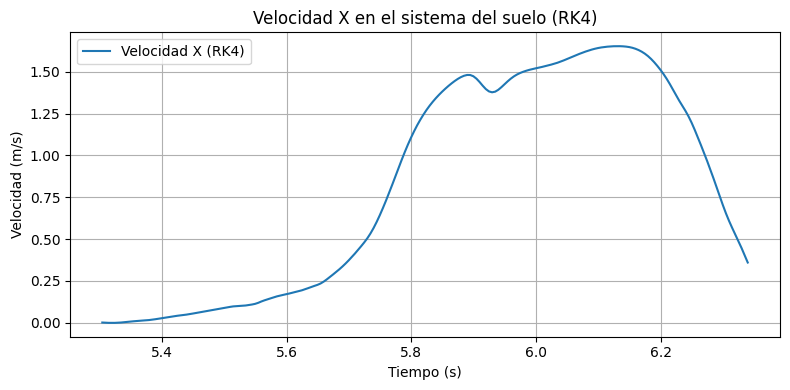

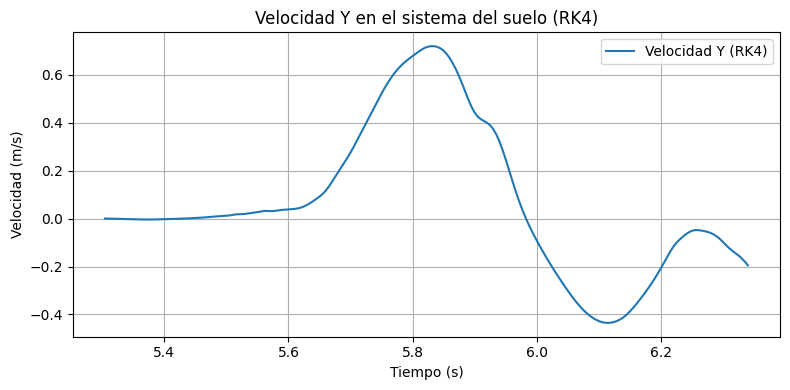

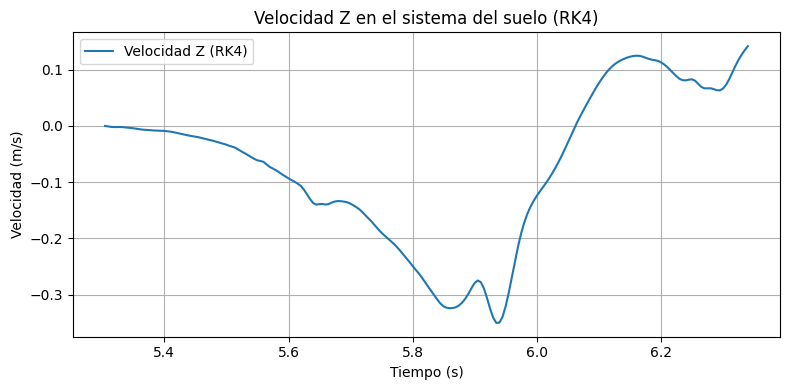

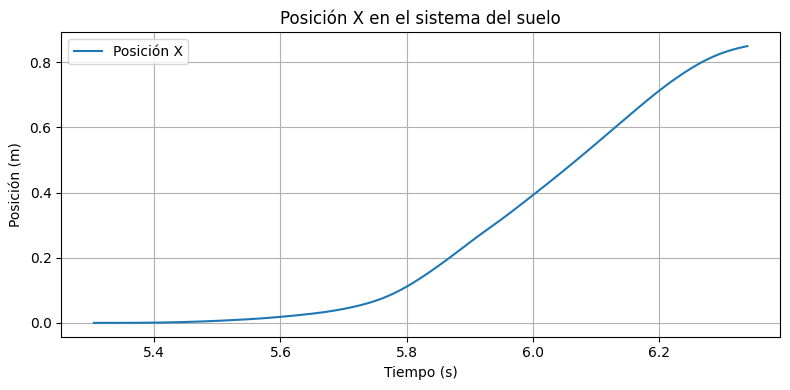

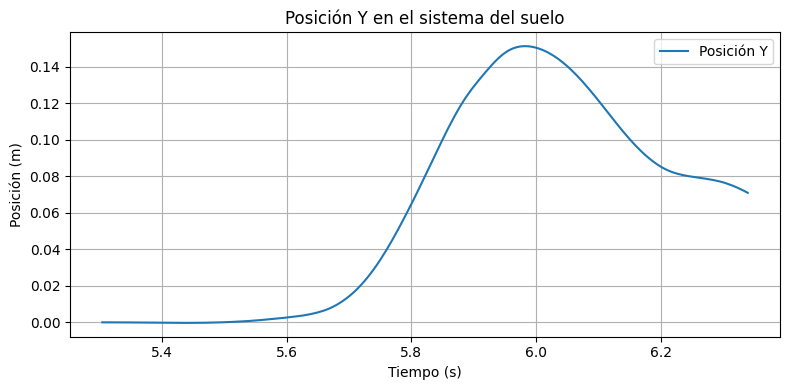

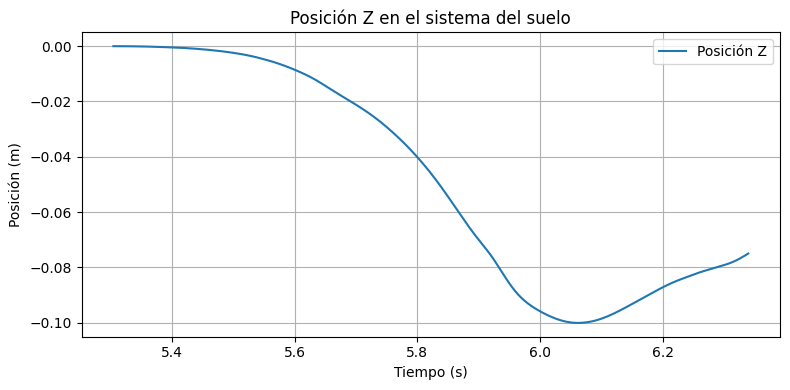

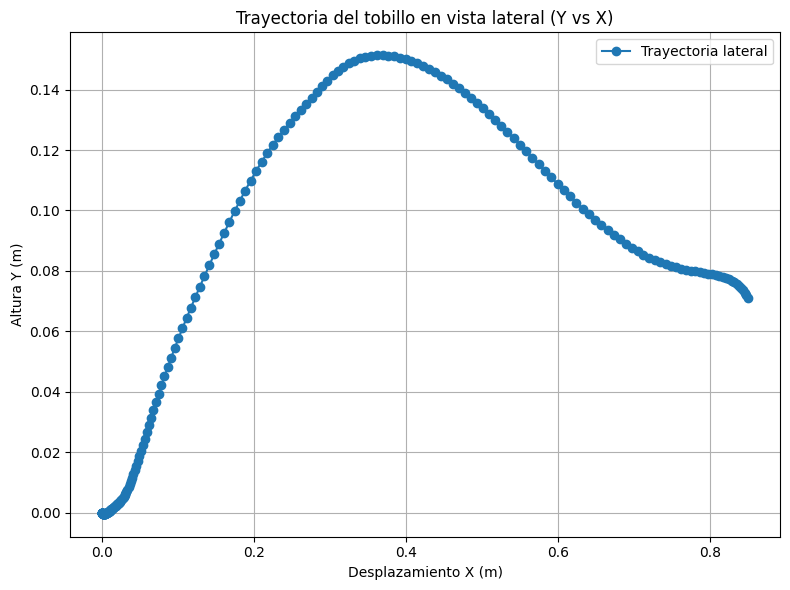

In [1]:
#Analisis del ciclo de paso, hasta el isntante de impactar el talon conn el suelo, obviando de esta manera en el analisis la sacudida del pie al 
#impactar y los picos que genera en las aceleraciones registradas.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.spatial.transform import Rotation as R

# 1) Cargar datos
acc_df = pd.read_csv('Accelerometer.csv')
gyr_df = pd.read_csv('Gyroscope.csv')

# 2) Recortar intervalo 5.30–6.34 s
t0, t1 = 5.30, 6.34
acc_df = acc_df[(acc_df['seconds_elapsed'] >= t0) & (acc_df['seconds_elapsed'] <= t1)].reset_index(drop=True)
gyr_df = gyr_df[(gyr_df['seconds_elapsed'] >= t0) & (gyr_df['seconds_elapsed'] <= t1)].reset_index(drop=True)

# 3) Interpolar giroscopio al tiempo del acelerómetro
acc_t = acc_df['seconds_elapsed'].values
gyr_t = gyr_df['seconds_elapsed'].values
gyro_interp = {}
for comp in ['x', 'y', 'z']:
    gyro_interp[comp] = np.interp(acc_t, gyr_t, gyr_df[comp].values)

# 4) Integrar orientación acumulando rotvecs
N = len(acc_t)
rots = [R.identity()]
for i in range(1, N):
    dt = acc_t[i] - acc_t[i-1]
    omega = np.array([gyro_interp['x'][i],
                      gyro_interp['y'][i],
                      gyro_interp['z'][i]])
    rotvec = omega * dt
    rots.append(rots[-1] * R.from_rotvec(rotvec))

# 5) Matrices de rotación
R_matrices = np.stack([r.as_matrix() for r in rots], axis=0)

# 6) Rotar aceleraciones al sistema del suelo
acc_sensor = acc_df[['x', 'y', 'z']].values
acc_lab = np.einsum('nij,nj->ni', R_matrices, acc_sensor)

# 7) Graficar aceleraciones originales y rotadas
componentes = ['X', 'Y', 'Z']
for i, comp in enumerate(componentes):
    plt.figure(figsize=(7,4))
    plt.plot(acc_t, acc_sensor[:,i], label=f'Aceleración {comp} (sensor)')
    plt.plot(acc_t, acc_lab[:,i], '--', label=f'Aceleración {comp} (suelo)')
    plt.title(f'Aceleración {comp}: sensor vs suelo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Aceleración (m/s²)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# 8) Integración RK4 para obtener velocidades
def rk4_integration(time, signal):
    v = np.zeros_like(signal)
    for i in range(1, len(time)):
        dt = time[i] - time[i-1]
        k1 = signal[i-1]
        k2 = 0.5 * (signal[i-1] + signal[i])
        k3 = k2
        k4 = signal[i]
        v[i] = v[i-1] + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return v

vel_lab = rk4_integration(acc_t, acc_lab)

# 9) Graficar velocidades
for i, comp in enumerate(componentes):
    plt.figure(figsize=(8, 4))
    plt.plot(acc_t, vel_lab[:, i], label=f'Velocidad {comp} (RK4)')
    plt.title(f'Velocidad {comp} en el sistema del suelo (RK4)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Velocidad (m/s)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# 10) Integración RK4 de velocidad -> posición
pos_lab = rk4_integration(acc_t, vel_lab)

# 11) Graficar posiciones en cada eje
for i, comp in enumerate(componentes):
    plt.figure(figsize=(8, 4))
    plt.plot(acc_t, pos_lab[:, i], label=f'Posición {comp}')
    plt.title(f'Posición {comp} en el sistema del suelo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Posición (m)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# 12) Graficar trayectoria lateral (Y vs X)
plt.figure(figsize=(8, 6))
plt.plot(pos_lab[:, 0], pos_lab[:, 1], marker='o', label='Trayectoria lateral')
plt.title('Trayectoria del tobillo en vista lateral (Y vs X)')
plt.xlabel('Desplazamiento X (m)')
plt.ylabel('Altura Y (m)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
